In [4]:
# @title 1. Setup and Configuration
!pip install -q mne pandas numpy scipy joblib tqdm

import os
import glob
import numpy as np
import pandas as pd
import mne
from pathlib import Path
from joblib import Parallel, delayed
import warnings

# Use threading backend for parallel processing to avoid RAM multiplication
PARALLEL_BACKEND = 'threading'

mne.set_log_level('ERROR')
warnings.filterwarnings("ignore")

# --- CONFIGURATION (Identical to previous step for consistency) ---
BASE_PATH = Path("F:\Rice\Rice F25\Seizure Project")
DATA_ROOT = BASE_PATH / 'Data'
OUTPUT_DIR = BASE_PATH / 'Processed_Gemini_V3'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Processing Constants
TARGET_SFREQ = 250
WINDOW_DUR = 2.0
OVERLAP = 0.50
WINDOW_SAMPLES = int(WINDOW_DUR * TARGET_SFREQ)
STEP_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))

RMS_THRESH_HIGH = 150e-6
RMS_THRESH_LOW = 13e-6

# Undersampling Ratio (1 Seizure : N Backgrounds)
BACKGROUND_RATIO = 5 

# Modality Settings
# NOTE: 'channels' is used for info, not strict shaping in this dynamic loop
MODALITY_CONFIG = {
    'eeg': {'l_freq': 0.5, 'h_freq': 40.0, 'notch': 50.0, 'type': 'eeg'},
    'ecg': {'l_freq': 0.5, 'h_freq': 40.0, 'notch': 50.0, 'type': 'ecg'},  # Recommended 0.5-40Hz
    'emg': {'l_freq': 20.0, 'h_freq': 100.0, 'notch': 50.0, 'type': 'emg'}, # Recommended 20-100Hz
    'mov': {'l_freq': 1.0, 'h_freq': 25.0, 'notch': None, 'type': 'misc'}   # Requested 1-25Hz
}

# Updated Channel Map to support Wearable names
CH_MAP = {
    'eeg': ['EEG', 'REF', 'BTE', 'CROSS'], # Added BTE and CROSS
    'ecg': ['ECG'],
    'emg': ['EMG', 'Deltoid'],
    'mov': ['ACC', 'GYR']
}

print("Configuration V3 Loaded. Root Data Path:", DATA_ROOT)

Configuration V3 Loaded. Root Data Path: F:\Rice\Rice F25\Seizure Project\Data


In [5]:
# @title 2. Helper Functions (Strict Discovery)

def apply_filters_v3(raw, modality):
    """Applies filters using IIR (Butterworth) as requested."""
    config = MODALITY_CONFIG[modality]
    
    # 1. Resample First (to unify timeline)
    if raw.info['sfreq'] != TARGET_SFREQ:
        raw.resample(TARGET_SFREQ, npad='auto', verbose=False)
        
    # 2. Filter (IIR Butterworth)
    # verbose=False to reduce clutter
    if config['l_freq'] is not None or config['h_freq'] is not None:
        raw.filter(config['l_freq'], config['h_freq'], 
                   method='iir', verbose=False)
                   
    # 3. Notch Filter
    if config['notch']:
        raw.notch_filter(config['notch'], method='iir', verbose=False)
        
    return raw

def load_seizure_mask_v3(tsv_path, n_samples, sfreq):
    """Parses TSV events into a binary mask."""
    mask = np.zeros(n_samples, dtype=np.int8)
    if not tsv_path.exists(): return mask

    try:
        df = pd.read_csv(tsv_path, sep='\t')
        # Filter relevant events
        valid_events = df[~df["eventType"].isin(["bckg", "impd"])]

        for _, row in valid_events.iterrows():
            evt_type = str(row.get('eventType', '')).lower()
            if any(x in evt_type for x in ['sz', 'seizure', 'focal', 'generalized']):
                onset = float(row['onset'])
                duration = float(row['duration'])
                start = int(onset * sfreq)
                end = int((onset + duration) * sfreq)
                start = max(0, start)
                end = min(n_samples, end)
                mask[start:end] = 1
    except Exception:
        pass # Fail silently if file is bad, mask remains 0
    return mask

def get_data_norm(raw_obj, min_samples):
    """Extracts, crops, and Z-score normalizes."""
    d = raw_obj.get_data()[:, :min_samples]
    mean = np.mean(d, axis=1, keepdims=True)
    std = np.std(d, axis=1, keepdims=True)
    return (d - mean) / (std + 1e-6)

# Re-using the discovery function from V2 as it was correct
def discover_valid_recordings_v3(data_root: Path):
    valid_sets = []
    eeg_files = sorted(data_root.glob("sub-*/ses-*/eeg/*_eeg.edf"))
    for eeg_path in eeg_files:
        base_name = eeg_path.name.replace('_eeg.edf', '')
        ses_dir = eeg_path.parent.parent
        ecg_path = ses_dir / 'ecg' / f"{base_name}_ecg.edf"
        emg_path = ses_dir / 'emg' / f"{base_name}_emg.edf"
        mov_path = ses_dir / 'mov' / f"{base_name}_mov.edf"
        evt_path = eeg_path.with_name(f"{base_name}_events.tsv")
        
        if eeg_path.exists() and ecg_path.exists() and emg_path.exists() and mov_path.exists():
            valid_sets.append({
                'run_id': base_name,
                'paths': {'eeg': eeg_path, 'ecg': ecg_path, 'emg': emg_path, 'mov': mov_path, 'evt': evt_path}
            })
    return valid_sets

In [6]:
# @title 3. Main Processing Loop (Fixed for NameError)
import random

def process_run_balanced_v3(rec_data):
    run_id = rec_data['run_id']
    paths = rec_data['paths']
    out_file = OUTPUT_DIR / f"{run_id}_balanced_v3.npz"

    if out_file.exists():
        return f"Skipped (Exists): {run_id}"

    try:
        raws = {}
        min_samples_list = []

        # --- 1. Load & Preprocess ---
        for mod, path in paths.items():
            if mod == 'evt': continue
            
            # Read
            raw = mne.io.read_raw_edf(path, preload=True, verbose='ERROR')
            
            # Pick Channels
            targets = CH_MAP[mod]
            picks = [ch for ch in raw.ch_names if any(t.lower() in ch.lower() for t in targets)]
            if not picks: return f"Error: No {mod} channels found for {run_id}"
            raw.pick_channels(picks)
            
            # Filter & Resample
            raw = apply_filters_v3(raw, mod)
            
            raws[mod] = raw
            min_samples_list.append(raw.n_times)

        min_samples = min(min_samples_list)
        if min_samples < WINDOW_SAMPLES:
            return f"Skipped: Too short {run_id}"

        # --- 2. Normalize & Stack ---
        X_eeg = get_data_norm(raws['eeg'], min_samples)
        X_student = np.concatenate([
            get_data_norm(raws['ecg'], min_samples),
            get_data_norm(raws['emg'], min_samples),
            get_data_norm(raws['mov'], min_samples)
        ], axis=0)
        
        # Load Labels
        y_full = load_seizure_mask_v3(paths['evt'], min_samples, TARGET_SFREQ)

        # --- 3. Windowing with Undersampling ---
        sz_windows = []
        bkg_windows = []
        
        raw_eeg_data = raws['eeg'].get_data()[:, :min_samples]

        for i in range(0, min_samples - WINDOW_SAMPLES + 1, STEP_SAMPLES):
            end = i + WINDOW_SAMPLES
            
            # RMS Check (Artifact Rejection)
            win_raw = raw_eeg_data[:, i:end]
            rms = np.sqrt(np.mean(win_raw**2, axis=1))
            if np.any(rms > RMS_THRESH_HIGH) or np.any(rms < RMS_THRESH_LOW):
                continue # Discard artifact

            # Label Check
            is_seizure = 1 if np.mean(y_full[i:end]) > 0.5 else 0
            
            # Store Window Data (Tuple: Teacher, Student, Label)
            win_data = (X_eeg[:, i:end], X_student[:, i:end], is_seizure)
            
            if is_seizure:
                sz_windows.append(win_data)
            else:
                bkg_windows.append(win_data)

        # --- 4. Apply Ratio (1 Sz : 5 Bkg) ---
        n_sz = len(sz_windows)
        if n_sz == 0:
             # Option: If no seizures, maybe keep a few backgrounds or skip?
             # User focused on balancing. If 0 seizures, usually skip file or keep very few.
             # Let's skip strictly to avoid pure noise files unless user wants them.
             return f"Skipped: No seizure windows found in {run_id}"
             
        target_bkg = n_sz * BACKGROUND_RATIO
        
        if len(bkg_windows) > target_bkg:
            # Randomly undersample background
            selected_bkg = random.sample(bkg_windows, target_bkg)
        else:
            selected_bkg = bkg_windows

        final_windows = sz_windows + selected_bkg
        random.shuffle(final_windows)

        # Unpack
        w_teacher = np.array([x[0] for x in final_windows], dtype=np.float32)
        w_student = np.array([x[1] for x in final_windows], dtype=np.float32)
        w_y = np.array([x[2] for x in final_windows], dtype=np.int8)

        # --- 5. Save ---
        np.savez_compressed(
            out_file,
            X_teacher=w_teacher,
            X_student=w_student,
            y=w_y
        )
        
        return f"Saved {len(w_y)} windows ({n_sz} Sz, {len(selected_bkg)} Bkg) for {run_id}"

    except Exception as e:
        return f"CRITICAL Error {run_id}: {str(e)}"

print("Processing Function Ready.")


# --- EXECUTION ---
# (The execution block remains the same)
print("Scanning Data Folder...")
valid_recs = discover_valid_recordings_v3(DATA_ROOT)
print(f"Found {len(valid_recs)} STRICT multimodal recordings.")

if len(valid_recs) > 0:
    print(f"Starting Parallel Processing on {len(valid_recs)} runs using '{PARALLEL_BACKEND}' backend...")
    results = Parallel(n_jobs=3, backend=PARALLEL_BACKEND, verbose=5)( 
        delayed(process_run_balanced_v3)(rec) for rec in valid_recs
    )
    
    saved = sum(1 for r in results if "Saved" in r)
    errors = [r for r in results if "CRITICAL Error" in r]
    
    print(f"\nProcessing Complete. Successfully saved {saved}/{len(valid_recs)} files.")
    if errors:
        print(f"Encountered {len(errors)} CRITICAL errors. These files still need manual diagnosis:")
        for err in errors:
            print(f"- {err}")
else:
    print("❌ No valid recordings found. Check DATA_ROOT path.")

Processing Function Ready.
Scanning Data Folder...
Found 2508 STRICT multimodal recordings.
Starting Parallel Processing on 2508 runs using 'threading' backend...


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 13.2min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 25.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 39.1min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 50.9min
[Parallel(n_jobs=3)]: Done 876 tasks      | elapsed: 61.4min
[Parallel(n_jobs=3)]: Done 1146 tasks      | elapsed: 67.3min
[Parallel(n_jobs=3)]: Done 1452 tasks      | elapsed: 70.1min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 73.2min
[Parallel(n_jobs=3)]: Done 2172 tasks      | elapsed: 96.3min



Processing Complete. Successfully saved 317/2508 files.


[Parallel(n_jobs=3)]: Done 2508 out of 2508 | elapsed: 99.8min finished


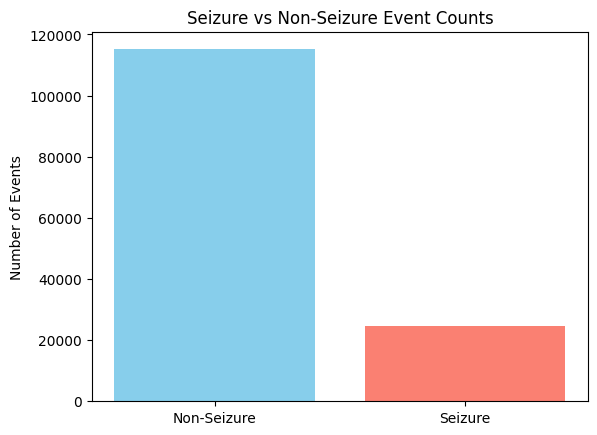

In [7]:
import numpy as np

import matplotlib.pyplot as plt

# Initialize counters
seizure_count = 0
non_seizure_count = 0

# Loop through all .npz files in OUTPUT_DIR
for npz_file in OUTPUT_DIR.glob("*.npz"):
    data = np.load(npz_file)
    y = data['y']
    seizure_count += np.sum(y == 1)
    non_seizure_count += np.sum(y == 0)

# Plotting
plt.bar(['Non-Seizure', 'Seizure'], [non_seizure_count, seizure_count], color=['skyblue', 'salmon'])
plt.ylabel('Number of Events')
plt.title('Seizure vs Non-Seizure Event Counts')
plt.show()


In [8]:

print(seizure_count, non_seizure_count)

24659 115122


In [3]:
from pathlib import Path

BASE_PATH = Path("F:\Rice\Rice F25\Seizure Project")
DATA_ROOT = BASE_PATH / 'Data'
OUTPUT_DIR = BASE_PATH / 'Processed_Gemini_V3'

# Define the two paths in question
path_v3 = OUTPUT_DIR
path_old = BASE_PATH / "Processed Class Balancing 3"

print("--- FOLDER INSPECTION ---")

# Check V3 (New)
if path_v3.exists():
    count_v3 = len(list(path_v3.glob("*.npz")))
    print(f"Processed_Gemini_V3 contains: {count_v3} files")
    print(f"   -> This matches the 'Saved 317' log (approx). These are the seizure-containing files.")
else:
    print(f"Processed_Gemini_V3: Not Found")

# Check Old
if path_old.exists():
    count_old = len(list(path_old.glob("*.npz")))
    print(f"Processed Class Balancing Z-Normalized contains: {count_old} files")
    print(f"   -> This matches the 2508 total input files. This is the unbalanced set.")
else:
    print(f"Processed Class Balancing Z-Normalized: Not Found")

print("\n--- TIME CALCULATION ---")
# Based on user provided counts
n_sz = 24659
n_bg = 115122
total_wins = n_sz + n_bg
window_dur = 2.0
overlap = 0.5

print(f"Total Windows: {total_wins:,}")
print(f"Total Training Duration (Windows * 2s): {total_wins * window_dur / 3600:.2f} hours")
print(f"Total Recording Coverage (Approx): {(total_wins * window_dur * (1-overlap)) / 3600:.2f} hours")

--- FOLDER INSPECTION ---
Processed_Gemini_V3 contains: 317 files
   -> This matches the 'Saved 317' log (approx). These are the seizure-containing files.
Processed Class Balancing Z-Normalized contains: 2506 files
   -> This matches the 2508 total input files. This is the unbalanced set.

--- TIME CALCULATION ---
Total Windows: 139,781
Total Training Duration (Windows * 2s): 77.66 hours
Total Recording Coverage (Approx): 38.83 hours


# Relaxed Preprocessing Pipeline (Undersampling Method)

In [3]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import random
import os

# --- 1. Configuration V4 ---
BASE_PATH = Path("F:\Rice\Rice F25\Seizure Project")
DATA_ROOT = BASE_PATH / 'Data'
OUTPUT_DIR_V4 = BASE_PATH / 'Processed_Gemini_V4'
OUTPUT_DIR_V4.mkdir(parents=True, exist_ok=True)

TARGET_SFREQ = 250
WINDOW_DUR = 2.0
OVERLAP = 0.50
WINDOW_SAMPLES = int(WINDOW_DUR * TARGET_SFREQ)
STEP_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))
BACKGROUND_RATIO = 5

RMS_THRESH_HIGH = 150e-6
RMS_THRESH_LOW = 13e-6

# Fixed channel counts for dummy data generation
STUDENT_CH_COUNTS = {
    'ecg': 1,
    'emg': 1,
    'mov': 6  # 3 ACC + 3 GYR
}

# --- 2. Discovery Function (Relaxed) ---
def discover_recordings_relaxed(data_root: Path):
    valid_sets = []
    # Find all EEG files
    eeg_files = sorted(data_root.glob("sub-*/ses-*/eeg/*_eeg.edf"))
    
    for eeg_path in eeg_files:
        base_name = eeg_path.name.replace('_eeg.edf', '')
        ses_dir = eeg_path.parent.parent
        
        # Define potential paths
        ecg_path = ses_dir / 'ecg' / f"{base_name}_ecg.edf"
        emg_path = ses_dir / 'emg' / f"{base_name}_emg.edf"
        mov_path = ses_dir / 'mov' / f"{base_name}_mov.edf"
        evt_path = eeg_path.with_name(f"{base_name}_events.tsv")
        
        # Store path if exists, else None
        paths = {
            'eeg': eeg_path,
            'ecg': ecg_path if ecg_path.exists() else None,
            'emg': emg_path if emg_path.exists() else None,
            'mov': mov_path if mov_path.exists() else None,
            'evt': evt_path
        }
        
        valid_sets.append({
            'run_id': base_name,
            'paths': paths
        })
        
    return valid_sets, len(eeg_files)

# --- 3. Processing Function (Relaxed V4) ---
def process_run_relaxed_v4(rec_data):
    run_id = rec_data['run_id']
    paths = rec_data['paths']
    out_file = OUTPUT_DIR_V4 / f"{run_id}_relaxed_v4.npz"
    
    if out_file.exists():
        return f"Skipped (Exists): {run_id}"

    try:
        # --- A. Load Teacher (EEG) ---
        raw_eeg = mne.io.read_raw_edf(paths['eeg'], preload=True, verbose='ERROR')
        
        # Pick Channels (Robust search)
        targets_eeg = ['EEG', 'REF', 'BTE', 'CROSS']
        picks_eeg = [ch for ch in raw_eeg.ch_names if any(t.lower() in ch.lower() for t in targets_eeg)]
        if not picks_eeg: 
            return f"Error: No EEG channels found for {run_id}"
        raw_eeg.pick_channels(picks_eeg)
        
        # Resample & Filter EEG
        if raw_eeg.info['sfreq'] != TARGET_SFREQ:
            raw_eeg.resample(TARGET_SFREQ, npad='auto', verbose=False)
        raw_eeg.filter(0.5, 40.0, method='iir', verbose=False)
        raw_eeg.notch_filter(50.0, method='iir', verbose=False)
        
        n_samples_common = raw_eeg.n_times
        
        # --- B. Load or Pad Student Modalities ---
        student_data_list = []
        
        for mod in ['ecg', 'emg', 'mov']:
            path = paths[mod]
            target_count = STUDENT_CH_COUNTS[mod]
            
            if path is not None:
                # 1. Load Real Data
                raw_mod = mne.io.read_raw_edf(path, preload=True, verbose='ERROR')
                
                # Filter
                if mod == 'ecg':
                    raw_mod.filter(0.5, 40.0, method='iir', verbose=False)
                    raw_mod.notch_filter(50.0, method='iir', verbose=False)
                elif mod == 'emg':
                    raw_mod.filter(20.0, 100.0, method='iir', verbose=False)
                    raw_mod.notch_filter(50.0, method='iir', verbose=False)
                elif mod == 'mov':
                    raw_mod.filter(1.0, 10.0, method='iir', verbose=False)
                
                # Resample
                if raw_mod.info['sfreq'] != 25: # 25 Hz sampling frequency for MOV
                    raw_mod.resample(25, npad='auto', verbose=False) # 25 Hz sampling frequency for MOV
                
                d = raw_mod.get_data()
                
                # 2. Align Samples (Crop/Pad time)
                if d.shape[1] > n_samples_common:
                    d = d[:, :n_samples_common]
                elif d.shape[1] < n_samples_common:
                    pad_width = n_samples_common - d.shape[1]
                    d = np.pad(d, ((0,0), (0, pad_width)), mode='constant')
                
                # 3. Align Channels (Slice/Pad count)
                if d.shape[0] >= target_count:
                    d = d[:target_count, :]
                else:
                    pad_ch = target_count - d.shape[0]
                    d = np.pad(d, ((0, pad_ch), (0,0)), mode='constant')
                
                # 4. Normalize (Z-score)
                mean = np.mean(d, axis=1, keepdims=True)
                std = np.std(d, axis=1, keepdims=True)
                d_norm = (d - mean) / (std + 1e-6)
                
                student_data_list.append(d_norm)
            else:
                # 1. Generate Dummy Data (Zeros)
                d_dummy = np.zeros((target_count, n_samples_common), dtype=np.float32)
                student_data_list.append(d_dummy)
        
        # Concatenate Students (ECG + EMG + MOV)
        X_student_full = np.concatenate(student_data_list, axis=0)
        
        # Normalize Teacher
        d_eeg = raw_eeg.get_data()[:, :n_samples_common]
        mean_eeg = np.mean(d_eeg, axis=1, keepdims=True)
        std_eeg = np.std(d_eeg, axis=1, keepdims=True)
        X_teacher_full = (d_eeg - mean_eeg) / (std_eeg + 1e-6)
        
        # --- C. Labels ---
        mask = np.zeros(n_samples_common, dtype=np.int8)
        if paths['evt'].exists():
            try:
                df_evt = pd.read_csv(paths['evt'], sep='\t')
                # Filter artifacts
                valid_evts = df_evt[~df_evt["eventType"].isin(["bckg", "impd"])]
                for _, row in valid_evts.iterrows():
                    evt_type = str(row.get('eventType', '')).lower()
                    if any(x in evt_type for x in ['sz', 'seizure', 'focal', 'generalized']):
                        onset = float(row['onset'])
                        duration = float(row['duration'])
                        start = int(onset * TARGET_SFREQ)
                        end = int((onset + duration) * TARGET_SFREQ)
                        start = max(0, start)
                        end = min(n_samples_common, end)
                        mask[start:end] = 1
            except:
                pass
        y_full = mask

        # --- D. Windowing & Balancing ---
        sz_windows = []
        bkg_windows = []
        
        if n_samples_common < WINDOW_SAMPLES:
             return f"Skipped: Too short {run_id}"

        for i in range(0, n_samples_common - WINDOW_SAMPLES + 1, STEP_SAMPLES):
            end = i + WINDOW_SAMPLES
            
            # RMS Artifact Check (Only on EEG raw)
            win_eeg_raw = d_eeg[:, i:end]
            rms = np.sqrt(np.mean(win_eeg_raw**2, axis=1))
            if np.any(rms > RMS_THRESH_HIGH) or np.any(rms < RMS_THRESH_LOW):
                continue

            # Label
            is_seizure = 1 if np.mean(y_full[i:end]) > 0.5 else 0
            
            # Data
            win_t = X_teacher_full[:, i:end]
            win_s = X_student_full[:, i:end]
            
            if is_seizure:
                sz_windows.append((win_t, win_s, 1))
            else:
                bkg_windows.append((win_t, win_s, 0))
                
        # Undersample Backgrounds
        n_sz = len(sz_windows)
        if n_sz == 0:
            return f"Skipped: No seizures in {run_id}"
            
        target_bkg = n_sz * BACKGROUND_RATIO
        if len(bkg_windows) > target_bkg:
            bkg_windows = random.sample(bkg_windows, target_bkg)
            
        final_wins = sz_windows + bkg_windows
        random.shuffle(final_wins)
        
        if not final_wins:
            return f"Skipped: No valid windows {run_id}"

        # --- E. Save ---
        X_teacher_out = np.array([w[0] for w in final_wins], dtype=np.float32)
        X_student_out = np.array([w[1] for w in final_wins], dtype=np.float32)
        y_out = np.array([w[2] for w in final_wins], dtype=np.int8)
        
        np.savez_compressed(
            out_file,
            X_teacher=X_teacher_out,
            X_student=X_student_out,
            y=y_out
        )
        
        return f"Saved {len(y_out)} windows ({n_sz} Sz) for {run_id}"

    except Exception as e:
        return f"Error {run_id}: {e}"

print("Relaxed Preprocessing Functions (V4) Defined and Ready.")

Relaxed Preprocessing Functions (V4) Defined and Ready.


In [4]:
from joblib import Parallel, delayed
import time

# --- EXECUTION V4 ---
print("Scanning Data (Relaxed Mode)...")
valid_recs, total_recs = discover_recordings_relaxed(DATA_ROOT)
print(f"Found {len(valid_recs)}/{total_recs} recordings with at least EEG.")

if valid_recs:
    print("Starting V4 Processing (Relaxed)... this may take a while.")
    start_time = time.time()
    
    # Run Parallel Processing
    results = Parallel(n_jobs=4, verbose=5)( 
        delayed(process_run_relaxed_v4)(rec) for rec in valid_recs 
    )

    # Summarize
    saved_count = sum(1 for r in results if "Saved" in r)
    skipped_count = sum(1 for r in results if "Skipped" in r)
    error_count = sum(1 for r in results if "Error" in r)
    
    elapsed = time.time() - start_time
    print(f"\nProcessing Complete in {elapsed/60:.2f} minutes.")
    print(f"Total: {len(valid_recs)}")
    print(f"Saved: {saved_count}")
    print(f"Skipped: {skipped_count}")
    print(f"Errors: {error_count}")

    # Show sample success/errors
    print("\nSample Results:")
    for r in results[:10]:
        print(f"  {r}")
else:
    print("No recordings found.")

Scanning Data (Relaxed Mode)...
Found 2850/2850 recordings with at least EEG.
Starting V4 Processing (Relaxed)... this may take a while.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 17.7min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 23.5min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed: 27.8min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 31.3min
[Parallel(n_jobs=4)]: Done 1458 tasks      | elapsed: 32.3min
[Parallel(n_jobs=4)]: Done 1800 tasks      | elapsed: 33.7min
[Parallel(n_jobs=4)]: Done 2178 tasks      | elapsed: 39.4min
[Parallel(n_jobs=4)]: Done 2592 tasks      | elapsed: 45.5min



Processing Complete in 46.37 minutes.
Total: 2850
Saved: 333
Skipped: 2517
Errors: 0

Sample Results:
  Skipped: No seizures in sub-001_ses-01_task-szMonitoring_run-01
  Skipped: No seizures in sub-001_ses-01_task-szMonitoring_run-02
  Saved 162 windows (27 Sz) for sub-001_ses-01_task-szMonitoring_run-03
  Skipped: No seizures in sub-001_ses-01_task-szMonitoring_run-04
  Saved 96 windows (16 Sz) for sub-001_ses-01_task-szMonitoring_run-05
  Skipped: No seizures in sub-001_ses-01_task-szMonitoring_run-06
  Saved 66 windows (11 Sz) for sub-001_ses-01_task-szMonitoring_run-07
  Saved 30 windows (5 Sz) for sub-001_ses-01_task-szMonitoring_run-08
  Skipped: No seizures in sub-001_ses-01_task-szMonitoring_run-09
  Saved 1002 windows (167 Sz) for sub-002_ses-01_task-szMonitoring_run-01


[Parallel(n_jobs=4)]: Done 2850 out of 2850 | elapsed: 46.4min finished


# Relaxed Preprocessing Pipeline (50% All Overlap/No Undersampling)

In [5]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import random
import os

# --- Configuration V4 No Undersample ---
# --- 1. Configuration V4 ---
BASE_PATH = Path("F:\Rice\Rice F25\Seizure Project")
DATA_ROOT = BASE_PATH / 'Data'
OUTPUT_DIR_V4_NO_UNDERSAMPLE = BASE_PATH / 'Processed_Gemini_V4_NoUndersample'
OUTPUT_DIR_V4_NO_UNDERSAMPLE.mkdir(parents=True, exist_ok=True)

# Constants (Re-defining to ensure scope context)
TARGET_SFREQ = 250 # Hz
WINDOW_DUR = 2.0 # seconds
OVERLAP = 0.50
WINDOW_SAMPLES = int(WINDOW_DUR * TARGET_SFREQ)
STEP_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))

RMS_THRESH_HIGH = 150e-6
RMS_THRESH_LOW = 13e-6

STUDENT_CH_COUNTS = {
    'ecg': 1,
    'emg': 1,
    'mov': 6
}

def process_run_relaxed_no_undersample(rec_data):
    run_id = rec_data['run_id']
    paths = rec_data['paths']
    out_file = OUTPUT_DIR_V4_NO_UNDERSAMPLE / f"{run_id}_v4_full.npz"

    if out_file.exists():
        return f"Skipped (Exists): {run_id}"

    try:
        # --- A. Load Teacher (EEG) ---
        raw_eeg = mne.io.read_raw_edf(paths['eeg'], preload=True, verbose='ERROR')

        # Pick Channels (Robust search)
        targets_eeg = ['EEG', 'REF', 'BTE', 'CROSS']
        picks_eeg = [ch for ch in raw_eeg.ch_names if any(t.lower() in ch.lower() for t in targets_eeg)]
        if not picks_eeg:
            return f"Error: No EEG channels found for {run_id}"
        raw_eeg.pick_channels(picks_eeg)

        # Resample & Filter EEG
        if raw_eeg.info['sfreq'] != TARGET_SFREQ:
            raw_eeg.resample(TARGET_SFREQ, npad='auto', verbose=False)
        raw_eeg.filter(0.5, 40.0, method='iir', verbose=False)
        raw_eeg.notch_filter(50.0, method='iir', verbose=False)

        n_samples_common = raw_eeg.n_times

        # --- B. Load or Pad Student Modalities ---
        student_data_list = []

        for mod in ['ecg', 'emg', 'mov']:
            path = paths[mod]
            target_count = STUDENT_CH_COUNTS[mod]

            if path is not None:
                # Load Real Data
                raw_mod = mne.io.read_raw_edf(path, preload=True, verbose='ERROR')

                # Filter
                if mod == 'ecg':
                    raw_mod.filter(0.5, 40.0, method='iir', verbose=False)
                    raw_mod.notch_filter(50.0, method='iir', verbose=False)
                elif mod == 'emg':
                    raw_mod.filter(20.0, 100.0, method='iir', verbose=False)
                    raw_mod.notch_filter(50.0, method='iir', verbose=False)
                elif mod == 'mov':
                    raw_mod.filter(1.0, 10.0, method='iir', verbose=False)

                # Resample
                if raw_mod.info['sfreq'] != 25: # 25 Hz sampling frequency for MOV
                    raw_mod.resample(25, npad='auto', verbose=False) # 25 Hz sampling frequency for MOV

                d = raw_mod.get_data()

                # Align Samples (Crop/Pad time)
                if d.shape[1] > n_samples_common:
                    d = d[:, :n_samples_common]
                elif d.shape[1] < n_samples_common:
                    pad_width = n_samples_common - d.shape[1]
                    d = np.pad(d, ((0,0), (0, pad_width)), mode='constant')

                # Align Channels (Slice/Pad count)
                if d.shape[0] >= target_count:
                    d = d[:target_count, :]
                else:
                    pad_ch = target_count - d.shape[0]
                    d = np.pad(d, ((0, pad_ch), (0,0)), mode='constant')

                # Normalize (Z-score)
                mean = np.mean(d, axis=1, keepdims=True)
                std = np.std(d, axis=1, keepdims=True)
                d_norm = (d - mean) / (std + 1e-6)

                student_data_list.append(d_norm)
            else:
                # Generate Dummy Data (Zeros)
                d_dummy = np.zeros((target_count, n_samples_common), dtype=np.float32)
                student_data_list.append(d_dummy)

        # Concatenate Students
        X_student_full = np.concatenate(student_data_list, axis=0)

        # Normalize Teacher
        d_eeg = raw_eeg.get_data()[:, :n_samples_common]
        mean_eeg = np.mean(d_eeg, axis=1, keepdims=True)
        std_eeg = np.std(d_eeg, axis=1, keepdims=True)
        X_teacher_full = (d_eeg - mean_eeg) / (std_eeg + 1e-6)

        # --- C. Labels ---
        mask = np.zeros(n_samples_common, dtype=np.int8)
        if paths['evt'].exists():
            try:
                df_evt = pd.read_csv(paths['evt'], sep='\t')
                valid_evts = df_evt[~df_evt["eventType"].isin(["bckg", "impd"])]
                for _, row in valid_evts.iterrows():
                    evt_type = str(row.get('eventType', '')).lower()
                    if any(x in evt_type for x in ['sz', 'seizure', 'focal', 'generalized']):
                        onset = float(row['onset'])
                        duration = float(row['duration'])
                        start = int(onset * TARGET_SFREQ)
                        end = int((onset + duration) * TARGET_SFREQ)
                        start = max(0, start)
                        end = min(n_samples_common, end)
                        mask[start:end] = 1
            except:
                pass
        y_full = mask

        # --- D. Windowing (NO UNDERSAMPLING) ---
        final_wins = []

        if n_samples_common < WINDOW_SAMPLES:
             return f"Skipped: Too short {run_id}"

        for i in range(0, n_samples_common - WINDOW_SAMPLES + 1, STEP_SAMPLES):
            end = i + WINDOW_SAMPLES

            # RMS Artifact Check (Only on EEG raw)
            win_eeg_raw = d_eeg[:, i:end]
            rms = np.sqrt(np.mean(win_eeg_raw**2, axis=1))
            if np.any(rms > RMS_THRESH_HIGH) or np.any(rms < RMS_THRESH_LOW):
                continue # Discard artifact

            # Label
            is_seizure = 1 if np.mean(y_full[i:end]) > 0.5 else 0

            # Data
            win_t = X_teacher_full[:, i:end]
            win_s = X_student_full[:, i:end]

            final_wins.append((win_t, win_s, is_seizure))

        n_sz = sum(1 for w in final_wins if w[2] == 1)
        n_bkg = len(final_wins) - n_sz

        # Only skip if strictly NO windows passed QC
        if not final_wins:
            return f"Skipped: No valid windows {run_id}"

        # --- E. Save ---
        X_teacher_out = np.array([w[0] for w in final_wins], dtype=np.float32)
        X_student_out = np.array([w[1] for w in final_wins], dtype=np.float32)
        y_out = np.array([w[2] for w in final_wins], dtype=np.int8)

        np.savez_compressed(
            out_file,
            X_teacher=X_teacher_out,
            X_student=X_student_out,
            y=y_out
        )

        return f"Saved {len(y_out)} windows ({n_sz} Sz, {n_bkg} Bkg) for {run_id}"

    except Exception as e:
        return f"Error {run_id}: {e}"

print("Processing Function (V4 No Undersample) Ready.")

Processing Function (V4 No Undersample) Ready.


In [7]:
from joblib import Parallel, delayed
import time
from pathlib import Path

# --- Ensure Path Definitions ---
# BASE_PATH was defined in previous cell, but redefining DATA_ROOT safely
# DATA_ROOT = Path("/content/drive/Shareddrives/AI Health Project/Project Code/Data")

# --- EXECUTION V4 (No Undersample) ---
print("Scanning Data (Relaxed Mode)...")
# Ensure discover_recordings_relaxed is available from previous cells
# If not defined in current scope, we assume it persists from cell 800d5519
valid_recs, total_recs = discover_recordings_relaxed(DATA_ROOT)
print(f"Found {len(valid_recs)}/{total_recs} recordings with at least EEG.")

if valid_recs:
    print("Starting V4 Processing (No Undersample)... this may take a while.")
    start_time = time.time()

    # Run Parallel Processing
    # Adjust n_jobs based on available CPU cores
    # Reduced to 2 to prevent memory issues causing worker crashes
    results = Parallel(n_jobs=5, verbose=5)(
        delayed(process_run_relaxed_no_undersample)(rec) for rec in valid_recs
    )

    # Summarize
    saved_count = sum(1 for r in results if "Saved" in r)
    skipped_count = sum(1 for r in results if "Skipped" in r)
    error_count = sum(1 for r in results if "Error" in r)

    elapsed = time.time() - start_time
    print(f"\nProcessing Complete in {elapsed/60:.2f} minutes.")
    print(f"Total: {len(valid_recs)}")
    print(f"Saved: {saved_count}")
    print(f"Skipped: {skipped_count}")
    print(f"Errors: {error_count}")

    # Show sample success/errors
    print("\nSample Results:")
    for r in results[:10]:
        print(f"  {r}")
else:
    print("No recordings found.")

Scanning Data (Relaxed Mode)...
Found 2850/2850 recordings with at least EEG.
Starting V4 Processing (No Undersample)... this may take a while.


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   15.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 12.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 24.4min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 31.8min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 33.4min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 35.1min
[Parallel(n_jobs=5)]: Done 2168 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 47.7min



Processing Complete in 49.03 minutes.
Total: 2850
Saved: 2839
Skipped: 11
Errors: 0

Sample Results:
  Skipped (Exists): sub-001_ses-01_task-szMonitoring_run-01
  Skipped (Exists): sub-001_ses-01_task-szMonitoring_run-02
  Skipped (Exists): sub-001_ses-01_task-szMonitoring_run-03
  Skipped (Exists): sub-001_ses-01_task-szMonitoring_run-04
  Saved 5021 windows (16 Sz, 5005 Bkg) for sub-001_ses-01_task-szMonitoring_run-05
  Skipped (Exists): sub-001_ses-01_task-szMonitoring_run-06
  Saved 4293 windows (11 Sz, 4282 Bkg) for sub-001_ses-01_task-szMonitoring_run-07
  Saved 3789 windows (5 Sz, 3784 Bkg) for sub-001_ses-01_task-szMonitoring_run-08
  Saved 1837 windows (0 Sz, 1837 Bkg) for sub-001_ses-01_task-szMonitoring_run-09
  Saved 2501 windows (167 Sz, 2334 Bkg) for sub-002_ses-01_task-szMonitoring_run-01


[Parallel(n_jobs=5)]: Done 2850 out of 2850 | elapsed: 49.0min finished


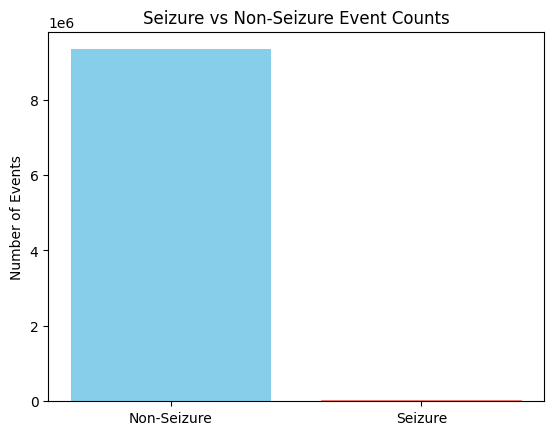

28973 9331897


In [9]:
import numpy as np

import matplotlib.pyplot as plt

# Initialize counters
seizure_count = 0
non_seizure_count = 0

# Loop through all .npz files in OUTPUT_DIR_V4_NO_UNDERSAMPLE
for npz_file in OUTPUT_DIR_V4_NO_UNDERSAMPLE.glob("*.npz"):
    data = np.load(npz_file)
    y = data['y']
    seizure_count += np.sum(y == 1)
    non_seizure_count += np.sum(y == 0)

# Plotting
plt.bar(['Non-Seizure', 'Seizure'], [non_seizure_count, seizure_count], color=['skyblue', 'salmon'])
plt.ylabel('Number of Events')
plt.title('Seizure vs Non-Seizure Event Counts')
plt.show()
print(seizure_count, non_seizure_count)

In [13]:
from pathlib import Path

BASE_PATH = Path("F:\Rice\Rice F25\Seizure Project")
DATA_ROOT = BASE_PATH / 'Data'
OUTPUT_DIR = BASE_PATH / 'Processed_Gemini_V4_NoUndersample'

# Define the two paths in question
path_v4 = OUTPUT_DIR
path_old = BASE_PATH / "Processed Class Balancing 3"

print("--- FOLDER INSPECTION ---")

# Check V3 (New)
if path_v4.exists():
    count_v4 = len(list(path_v4.glob("*.npz")))
    print(f"Processed_Gemini_V4_NoUndersample contains: {count_v4} files")
    print(f"   -> This matches the 'Saved 2839' log (approx). These are the seizure-containing files.")
else:
    print(f"Processed_Gemini_V4_NoUndersample: Not Found")

print("\n--- TIME CALCULATION ---")
# Based on user provided counts
n_sz = seizure_count
n_bg = non_seizure_count
total_wins = n_sz + n_bg
window_dur = 2.0
overlap = 0.5

print(f"Total Windows: {total_wins:,}")
print(f"Total Training Duration (Windows * 2s): {total_wins * window_dur / 3600:.2f} hours")
print(f"Total Recording Coverage (Approx): {(total_wins * window_dur * (1-overlap)) / 3600:.2f} hours")

--- FOLDER INSPECTION ---
Processed_Gemini_V4_NoUndersample contains: 2844 files
   -> This matches the 'Saved 2839' log (approx). These are the seizure-containing files.

--- TIME CALCULATION ---
Total Windows: 9,360,870
Total Training Duration (Windows * 2s): 5200.48 hours
Total Recording Coverage (Approx): 2600.24 hours


# Relaxed Preprocessing Pipeline (75% Seizure/50% Background Overlap/No Undersampling)

In [17]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import os

# --- Configuration V5 Augmented ---
BASE_PATH = Path("F:\Rice\Rice F25\Seizure Project")
DATA_ROOT = BASE_PATH / 'Data'
OUTPUT_DIR_V5 = BASE_PATH / 'Processed_Gemini_V5_Augmented'
OUTPUT_DIR_V5.mkdir(parents=True, exist_ok=True)

# Constants
SFREQ_HIGH = 250
SFREQ_LOW = 25
WINDOW_DUR = 2.0

# Stride settings (Dynamic Overlap)
STRIDE_SZ = 0.5   # 75% overlap (2.0s window, move 0.5s)
STRIDE_BKG = 1.0  # 50% overlap (2.0s window, move 1.0s)

RMS_THRESH_HIGH = 150e-6
RMS_THRESH_LOW = 13e-6

STUDENT_CH_COUNTS = {
    'ecg': 1,
    'emg': 1,
    'mov': 6
}

def process_run_v5_augmented(rec_data):
    run_id = rec_data['run_id']
    paths = rec_data['paths']
    out_file = OUTPUT_DIR_V5 / f"{run_id}_v5_aug.npz"

    if out_file.exists():
        return f"Skipped (Exists): {run_id}"

    try:
        # --- A. Load Teacher (EEG) @ 250Hz ---
        raw_eeg = mne.io.read_raw_edf(paths['eeg'], preload=True, verbose='ERROR')

        # Pick Channels
        targets_eeg = ['EEG', 'REF', 'BTE', 'CROSS']
        picks_eeg = [ch for ch in raw_eeg.ch_names if any(t.lower() in ch.lower() for t in targets_eeg)]
        if not picks_eeg: return f"Error: No EEG channels found for {run_id}"
        raw_eeg.pick_channels(picks_eeg)

        # Process EEG
        if raw_eeg.info['sfreq'] != SFREQ_HIGH:
            raw_eeg.resample(SFREQ_HIGH, npad='auto', verbose=False)
        raw_eeg.filter(0.5, 40.0, method='iir', verbose=False)
        raw_eeg.notch_filter(50.0, method='iir', verbose=False)

        n_samples_high = raw_eeg.n_times
        duration_sec = n_samples_high / SFREQ_HIGH

        # --- B. Load Student Bio (ECG/EMG) @ 250Hz ---
        bio_data_list = []
        for mod in ['ecg', 'emg']:
            path = paths[mod]
            target_count = STUDENT_CH_COUNTS[mod]
            if path is not None:
                raw_mod = mne.io.read_raw_edf(path, preload=True, verbose='ERROR')
                # Filter
                if mod == 'ecg':
                    raw_mod.filter(0.5, 40.0, method='iir', verbose=False)
                    raw_mod.notch_filter(50.0, method='iir', verbose=False)
                elif mod == 'emg':
                    raw_mod.filter(20.0, 100.0, method='iir', verbose=False)
                    raw_mod.notch_filter(50.0, method='iir', verbose=False)

                if raw_mod.info['sfreq'] != SFREQ_HIGH:
                    raw_mod.resample(SFREQ_HIGH, npad='auto', verbose=False)

                d = raw_mod.get_data()
                # Align Time
                if d.shape[1] > n_samples_high:
                    d = d[:, :n_samples_high]
                elif d.shape[1] < n_samples_high:
                    pad_width = n_samples_high - d.shape[1]
                    d = np.pad(d, ((0,0), (0, pad_width)), mode='constant')

                # Align Channels
                if d.shape[0] >= target_count:
                    d = d[:target_count, :]
                else:
                    d = np.pad(d, ((0, target_count - d.shape[0]), (0,0)), mode='constant')

                # Norm
                d = (d - np.mean(d, axis=1, keepdims=True)) / (np.std(d, axis=1, keepdims=True) + 1e-6)
                bio_data_list.append(d)
            else:
                bio_data_list.append(np.zeros((target_count, n_samples_high), dtype=np.float32))

        X_bio_full = np.concatenate(bio_data_list, axis=0)

        # --- C. Load Student MOV @ 25Hz ---
        path_mov = paths['mov']
        target_count_mov = STUDENT_CH_COUNTS['mov']
        n_samples_low = int(duration_sec * SFREQ_LOW)

        if path_mov is not None:
            raw_mov = mne.io.read_raw_edf(path_mov, preload=True, verbose='ERROR')
            # Filter 1-10Hz as requested for V5
            raw_mov.filter(1.0, 10.0, method='iir', verbose=False)
            # Resample to 25Hz
            if raw_mov.info['sfreq'] != SFREQ_LOW:
                raw_mov.resample(SFREQ_LOW, npad='auto', verbose=False)

            d_mov = raw_mov.get_data()
             # Align Time (Low Freq)
            if d_mov.shape[1] > n_samples_low:
                d_mov = d_mov[:, :n_samples_low]
            elif d_mov.shape[1] < n_samples_low:
                d_mov = np.pad(d_mov, ((0,0), (0, n_samples_low - d_mov.shape[1])), mode='constant')

            # Align Channels
            if d_mov.shape[0] >= target_count_mov:
                d_mov = d_mov[:target_count_mov, :]
            else:
                d_mov = np.pad(d_mov, ((0, target_count_mov - d_mov.shape[0]), (0,0)), mode='constant')

            # Norm
            d_mov = (d_mov - np.mean(d_mov, axis=1, keepdims=True)) / (np.std(d_mov, axis=1, keepdims=True) + 1e-6)
            X_mov_full = d_mov
        else:
            X_mov_full = np.zeros((target_count_mov, n_samples_low), dtype=np.float32)

        # Prepare EEG Data for Windowing
        X_eeg_raw_full = raw_eeg.get_data()[:, :n_samples_high]
        # We need the normalized version for storage (Teacher Model input)
        X_eeg_norm_full = (X_eeg_raw_full - np.mean(X_eeg_raw_full, axis=1, keepdims=True)) / (np.std(X_eeg_raw_full, axis=1, keepdims=True) + 1e-6)

        # --- D. Labels ---
        mask = np.zeros(n_samples_high, dtype=np.int8)
        if paths['evt'].exists():
            try:
                df_evt = pd.read_csv(paths['evt'], sep='\t')
                valid_evts = df_evt[~df_evt["eventType"].isin(["bckg", "impd"])]
                for _, row in valid_evts.iterrows():
                    evt_type = str(row.get('eventType', '')).lower()
                    if any(x in evt_type for x in ['sz', 'seizure', 'focal', 'generalized']):
                        onset = float(row['onset'])
                        duration = float(row['duration'])
                        start = int(onset * SFREQ_HIGH)
                        end = int((onset + duration) * SFREQ_HIGH)
                        start = max(0, start)
                        end = min(n_samples_high, end)
                        mask[start:end] = 1
            except: pass
        y_full = mask

        # --- E. Dynamic Windowing (FIXED) ---
        windows_teacher = []
        windows_bio = []
        windows_mov = []
        windows_y = []

        current_time = 0.0
        win_dur_sec = WINDOW_DUR

        while current_time + win_dur_sec <= duration_sec:
            # Indices for High Freq (250Hz)
            start_idx_high = int(current_time * SFREQ_HIGH)
            end_idx_high = int((current_time + win_dur_sec) * SFREQ_HIGH)

            # Indices for Low Freq (25Hz) - DEFINED HERE (FIXED)
            start_idx_low = int(current_time * SFREQ_LOW)
            end_idx_low = int((current_time + win_dur_sec) * SFREQ_LOW)

            # Safety Check
            if end_idx_high > n_samples_high or end_idx_low > X_mov_full.shape[1]:
                break

            # RMS Check (EEG) - USING RAW DATA (FIXED)
            win_eeg_raw = X_eeg_raw_full[:, start_idx_high:end_idx_high]
            rms = np.sqrt(np.mean(win_eeg_raw**2, axis=1))
            
            if np.any(rms > RMS_THRESH_HIGH) or np.any(rms < RMS_THRESH_LOW):
                # Skip artifact, move by background stride
                current_time += STRIDE_BKG
                continue

            # Label Check
            win_y = y_full[start_idx_high:end_idx_high]
            is_seizure = 1 if np.mean(win_y) > 0.5 else 0

            # Extract - USING NORMALIZED DATA FOR TEACHER (FIXED)
            win_eeg = X_eeg_norm_full[:, start_idx_high:end_idx_high]
            win_bio = X_bio_full[:, start_idx_high:end_idx_high]
            win_mov = X_mov_full[:, start_idx_low:end_idx_low] # Uses the calculated low indices

            # Store
            windows_teacher.append(win_eeg)
            windows_bio.append(win_bio)
            windows_mov.append(win_mov)
            windows_y.append(is_seizure)

            # Dynamic Stride Update
            if is_seizure:
                current_time += STRIDE_SZ
            else:
                current_time += STRIDE_BKG

        if not windows_y:
            return f"Skipped: No valid windows {run_id}"

        # Convert to Arrays
        X_t_out = np.array(windows_teacher, dtype=np.float32)
        X_b_out = np.array(windows_bio, dtype=np.float32)
        X_m_out = np.array(windows_mov, dtype=np.float32)
        y_out = np.array(windows_y, dtype=np.int8)

        n_sz = np.sum(y_out)
        n_bkg = len(y_out) - n_sz

        np.savez_compressed(
            out_file,
            X_teacher=X_t_out,
            X_student_bio=X_b_out,
            X_student_mov=X_m_out,
            y=y_out
        )

        return f"Saved {len(y_out)} wins ({n_sz} Sz, {n_bkg} Bkg) for {run_id}"

    except Exception as e:
        return f"Error {run_id}: {str(e)}"

print("V5 Augmented Processing Function Defined.")

V5 Augmented Processing Function Defined.


In [18]:
from joblib import Parallel, delayed
import time

# --- EXECUTION V5 (Augmented) ---
print("Starting V5 Augmented Processing...")

# Ensure valid_recs exists (from previous steps)
if 'valid_recs' in locals() and valid_recs:
    start_time = time.time()

    # Execute parallel processing
    # Using n_jobs=2 to prevent memory issues as observed in previous runs
    results = Parallel(n_jobs=5, verbose=5)(
        delayed(process_run_v5_augmented)(rec) for rec in valid_recs
    )

    # Generate Summary
    saved = sum(1 for r in results if "Saved" in r)
    skipped = sum(1 for r in results if "Skipped" in r)
    errors = sum(1 for r in results if "Error" in r)

    elapsed = time.time() - start_time
    print(f"\nProcessing Complete in {elapsed/60:.2f} minutes.")
    print(f"Total Recordings: {len(valid_recs)}")
    print(f"Saved: {saved}")
    print(f"Skipped: {skipped}")
    print(f"Errors: {errors}")

    print("\nSample Results:")
    for r in results[:5]:
        print(f"  {r}")
else:
    print("Error: 'valid_recs' variable not found. Please check if the discovery step was run successfully.")

Starting V5 Augmented Processing...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   24.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 12.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 19.7min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 25.6min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 33.7min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 35.3min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 36.9min
[Parallel(n_jobs=5)]: Done 2168 tasks      | elapsed: 42.8min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 50.0min



Processing Complete in 51.68 minutes.
Total Recordings: 2850
Saved: 2844
Skipped: 6
Errors: 0

Sample Results:
  Saved 1533 wins (0 Sz, 1533 Bkg) for sub-001_ses-01_task-szMonitoring_run-01
  Saved 2405 wins (0 Sz, 2405 Bkg) for sub-001_ses-01_task-szMonitoring_run-02
  Saved 7280 wins (48 Sz, 7232 Bkg) for sub-001_ses-01_task-szMonitoring_run-03
  Saved 5148 wins (0 Sz, 5148 Bkg) for sub-001_ses-01_task-szMonitoring_run-04
  Saved 5029 wins (29 Sz, 5000 Bkg) for sub-001_ses-01_task-szMonitoring_run-05


[Parallel(n_jobs=5)]: Done 2850 out of 2850 | elapsed: 51.7min finished


In [20]:
# --- Window / stride settings (must match your preprocessing) ---
WINDOW_DUR = 2.0   # seconds
STRIDE_SZ  = 0.5   # seconds (seizure windows)
STRIDE_BKG = 1.0   # seconds (background windows)

print("--- FOLDER INSPECTION (V5 Augmented) ---")

if OUTPUT_DIR_V5.exists():
    npz_files = sorted(OUTPUT_DIR_V5.glob("*.npz"))
    print(f"Processed_Gemini_V5_Augmented contains: {len(npz_files)} files")
else:
    print(f"Processed_Gemini_V5_Augmented: Not Found")
    npz_files = []

print("\n--- TIME CALCULATION (from V5 .npz) ---")

total_wins = 0
n_sz_total = 0
n_bkg_total = 0

for f in npz_files:
    try:
        data = np.load(f)
        y = data["y"]              # shape: (n_windows,)
        total_wins += len(y)
        n_sz = int(np.sum(y))
        n_bkg = len(y) - n_sz

        n_sz_total  += n_sz
        n_bkg_total += n_bkg
    except Exception as e:
        print(f"Warning: could not read {f.name}: {e}")

if total_wins == 0:
    print("No windows found. Check that V5 files exist and contain 'y'.")
else:
    print(f"Total Files Counted: {len(npz_files)}")
    print(f"Total Windows: {total_wins:,}")
    print(f"  - Seizure Windows: {n_sz_total:,}")
    print(f"  - Background Windows: {n_bkg_total:,}")

    # 1) Total training duration if every window is treated as a 2-second sample
    total_train_hours = (total_wins * WINDOW_DUR) / 3600.0

    # 2) Approximate *recording coverage* using dynamic stride:
    #    each seizure window advances timeline by STRIDE_SZ,
    #    each background window advances by STRIDE_BKG
    total_coverage_sec = n_sz_total * STRIDE_SZ + n_bkg_total * STRIDE_BKG
    total_coverage_hours = total_coverage_sec / 3600.0

    print(f"\nEstimated Total Training Duration (windows × {WINDOW_DUR:.1f}s): "
          f"{total_train_hours:.2f} hours")
    print(f"Approximate Recording Coverage (dynamic strides): "
          f"{total_coverage_hours:.2f} hours")

    # Optional: break out seizure vs background coverage
    sz_coverage_hours  = (n_sz_total * STRIDE_SZ) / 3600.0
    bkg_coverage_hours = (n_bkg_total * STRIDE_BKG) / 3600.0
    print(f"  - Seizure coverage (approx):   {sz_coverage_hours:.2f} hours")
    print(f"  - Background coverage (approx): {bkg_coverage_hours:.2f} hours")

--- FOLDER INSPECTION (V5 Augmented) ---
Processed_Gemini_V5_Augmented contains: 2844 files

--- TIME CALCULATION (from V5 .npz) ---
Total Files Counted: 2844
Total Windows: 9,383,242
  - Seizure Windows: 56,424
  - Background Windows: 9,326,818

Estimated Total Training Duration (windows × 2.0s): 5212.91 hours
Approximate Recording Coverage (dynamic strides): 2598.62 hours
  - Seizure coverage (approx):   7.84 hours
  - Background coverage (approx): 2590.78 hours


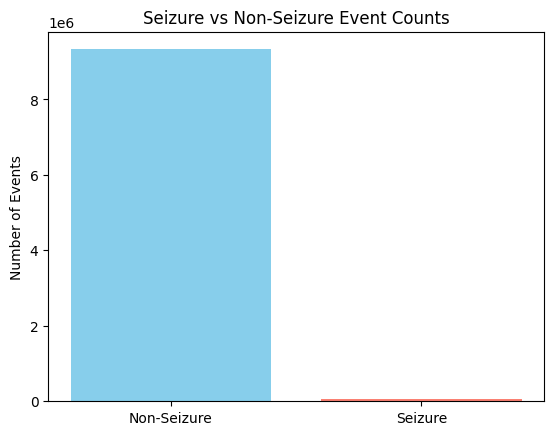

56424 9326818


In [21]:
import numpy as np

import matplotlib.pyplot as plt

# Initialize counters
seizure_count = 0
non_seizure_count = 0

# Loop through all .npz files in OUTPUT_DIR_V5
for npz_file in OUTPUT_DIR_V5.glob("*.npz"):
    data = np.load(npz_file)
    y = data['y']
    seizure_count += np.sum(y == 1)
    non_seizure_count += np.sum(y == 0)

# Plotting
plt.bar(['Non-Seizure', 'Seizure'], [non_seizure_count, seizure_count], color=['skyblue', 'salmon'])
plt.ylabel('Number of Events')
plt.title('Seizure vs Non-Seizure Event Counts')
plt.show()
print(seizure_count, non_seizure_count)